# Trabajo de título
## Verificación de la complementariedad entre las tecnologías de generación renovables en Chile y servicios complementarios asociados

#### Estudiante: Bryan Levy
#### Profesor guía: Rodrigo Palma

## Importando librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
import geopandas as gpd
import seaborn as sn
import glob
from google.colab import files

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (679 kB/s)
Selecting previously unselected package libspatialindex

## Data 

Los datos extraídos de la página del Coordinador Eléctrico corresponden a la generación real durante el periodo comprendido entre enero de 2020 y diciembre de 2022

In [ ]:
# Creación de función para importar generación de cada central, en resolución horaria

def cargar_dataset():

    # Vectores que contienen los archivos de los años 2020, 2021 y 2022

    files = ['2020-1.tsv', '2020-2.tsv', '2020-3.tsv', '2020-4.tsv','2020-5.tsv','2020-6.tsv',
            '2020-7.tsv','2020-8.tsv','2020-9.tsv','2020-10.tsv','2020-11.tsv','2020-12.tsv',
            '2021-1.tsv', '2021-2.tsv', '2021-3.tsv', '2021-4.tsv','2021-5.tsv','2021-6.tsv',
            '2021-7.tsv','2021-8.tsv','2021-9.tsv','2021-10.tsv','2021-11.tsv','2021-12.tsv']

    # Enlace 'raw' a GitHub que contiene los archivos

    link = 'https://raw.githubusercontent.com/BryanLevy/Memoria/main/Datos%202020-2022/'

    df = pd.DataFrame()  # Se crea el dataframe
    for f in files:  # Acciones a realizar para cada archivo en el vector
        file = link + f  # Se concatena el nombre del archivo al enlace, obteniendo la ubicación de cada archivo
        aux = pd.read_csv(file, sep='\t')  # Se lee en una varbiable auxiliar la información de cada archivo
        df = pd.concat([df,aux])  # Se concatena la información leída de cada archivo al dataframe
    
    df =df.reset_index()  # Se reinicia el índice del dataframe
    
    df = df.drop(df[df['hora_opreal'] > 24].index) # Se borran datos que se encuentran operando en horas imposibles
    df['hora_opreal'] = df['hora_opreal'] - 1  # Se ajusta el rango de operación diario entre las 00:00 hasta las 23:00 hrs 

    df['time'] = df['fecha_opreal'] + ' ' + df['hora_opreal'].astype('str')+':00:00'  # Se define un parámetro que incluye la fecha y la hora de operación
    df['time'] = df['time'].str.replace('-','/')  # Se reemplazan los slash de la fecha por guiones
    df['time'] = pd.to_datetime(df['time'])  # Se deja en formato de tiempo compatible con pandas la fecha y hora de cada dato 
    
    return df  # Se termina de definir la función, retornando df

df = cargar_dataset()  # Se llama a la función recién creada
df = df.drop('central_tipo_nemotecnico', axis=1)  # Se elimina la columna que tiene este parámetro, ya que no se va a utilizar
df  # Se entrega un preview del DataFrame

,index,fecha_opreal,hora_opreal,central_infotecnica_id,central_nombre,central_tipo,generacion_real_mwh,generacion_real_ernc_mwh,time
0,0,2020-01-01,0,163,HP LIRCAY,Hidráulica,17.400000,17.400000,2020-01-01 00:00:00
1,1,2020-01-01,0,443,PMGD PFV EL LAUREL,Solar,0.000000,0.000000,2020-01-01 00:00:00
2,2,2020-01-01,0,262,PMGD HP EL LLANO,Hidráulica,0.887921,0.887921,2020-01-01 00:00:00
3,3,2020-01-01,0,264,HE ANGOSTURA,Hidráulica,47.000000,0.000000,2020-01-01 00:00:00
4,4,2020-01-01,0,591,PMGD TER ALMENDRADO,Térmica,0.000000,0.000000,2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
11247894,555979,2021-12-31,20,1909,PMGD PFV ERINOME [EN_REVISION],Solar,0.024680,0.024680,2021-12-31 20:00:00
11247895,555980,2021-12-31,20,1910,PMGD PFV PACHIRA,Solar,0.000000,0.000000,2021-12-31 20:00:00
11247896,555981,2021-12-31,20,1914,PMGD PFV EL CASTAÑO,Solar,0.000000,0.000000,2021-12-31 20:00:00
11247897,555982,2021-12-31,20,1915,PMGD PFV SANTA MARGARITA,Solar,0.240735,0.240735,2021-12-31 20:00:00


## Manejo y limpieza de datos

In [ ]:
# Se crea otra variable 'gt' para separar los datos de generación de los de la demanda

gt = df #.pivot_table(values='generacion_real_mwh', columns='central_nombre',index='time')
# El dataset extraído corresponde a todas las centrales del país, por lo que extraemos sólo las de interés.

# Datos de generación y la demanda

solar = df[df['central_tipo']=='Solar'] #Datos de las centrales solares.
eolica = df[df['central_tipo']=='Eólica'] # Datos de las centrales eólicas.
#hidraulica = df[df['central_tipo']=='Hidráulica'] # Se extrae datos de las centrales hidráulicas.
load = gt.pivot_table(values='generacion_real_mwh', columns='central_nombre',index='time') # Demanda como la suma de toda la generación en el SEN

df = pd.concat([solar,eolica])  # Se concatenan los datos extraídos, estando los PFV primero.
df = df.sort_values(['time'], ascending=True)  # Se reordenan los datos por fecha y hora, de enero a diciembre.
df = df.reset_index()  # Se resetea el indice del dataframe luego de reordenar los datos.

eol = eolica.pivot_table(values='generacion_real_ernc_mwh', columns='central_nombre', index='time')  # Se deja como indice la hora del día (filas), mostrando la generación y cada central en las columnas.
sol = solar.pivot_table(values='generacion_real_ernc_mwh', columns='central_nombre', index='time')  # Se deja como indice la hora del día (filas), mostrando la generación y cada central en las columnas.
#hid = hidraulica.pivot_table(values='generacion_real_ernc_mwh', columns='central_nombre', index='time')  # Se deja como indice la hora del día (filas), mostrando la generación y cada central en las columnas.

df

,level_0,index,fecha_opreal,hora_opreal,central_infotecnica_id,central_nombre,central_tipo,generacion_real_mwh,generacion_real_ernc_mwh,time
0,1,1,2020-01-01,0,443,PMGD PFV EL LAUREL,Solar,0.0,0.0,2020-01-01 00:00:00
1,398,398,2020-01-01,0,439,PMGD PFV EL SAUCE,Solar,0.0,0.0,2020-01-01 00:00:00
2,401,401,2020-01-01,0,606,PMGD PFV PEDREROS SOLAR,Solar,0.0,0.0,2020-01-01 00:00:00
3,402,402,2020-01-01,0,367,PMGD PFV BELLAVISTA,Solar,0.0,0.0,2020-01-01 00:00:00
4,410,410,2020-01-01,0,399,PFV FINIS TERRAE,Solar,0.0,0.0,2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
5175444,11235455,543540,2021-12-31,23,1723,PMGD PFV CATEMU,Solar,0.0,0.0,2021-12-31 23:00:00
5175445,11235458,543543,2021-12-31,23,1724,PMGD PFV EL CHUCAO,Solar,0.0,0.0,2021-12-31 23:00:00
5175446,11235461,543546,2021-12-31,23,1725,PMGD PFV JAHUEL,Solar,0.0,0.0,2021-12-31 23:00:00
5175447,11235548,543633,2021-12-31,23,1755,PMGD PFV VICTORIA,Solar,0.0,0.0,2021-12-31 23:00:00


## Factor de planta generación ERNC

In [ ]:
# Función para eliminar plantas que se encuentran operativas un tiempo menor al umbral seleccionado

def quitar_plantas_de_prueba(df,umbral=0.2):

    # Fecha y hora de inicio y término para cada mes

    start_dates=['2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00',
                 '2020-05-01 00:00:00', '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00',
                 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00',
                 '2021-01-01 00:00:00', '2021-02-01 00:00:00', '2021-03-01 00:00:00', '2021-04-01 00:00:00',
                 '2021-05-01 00:00:00', '2021-06-01 00:00:00', '2021-07-01 00:00:00', '2021-08-01 00:00:00',
                 '2021-09-01 00:00:00', '2021-10-01 00:00:00', '2021-11-01 00:00:00', '2021-12-01 00:00:00']
    end_dates=['2020-01-31 23:00:00', '2020-02-28 23:00:00', '2020-03-31 23:00:00', '2020-04-30 23:00:00',
               '2020-05-31 23:00:00', '2020-06-30 23:00:00', '2020-07-31 23:00:00', '2020-08-31 23:00:00',
               '2020-09-30 23:00:00', '2020-10-31 23:00:00', '2020-11-30 23:00:00', '2020-12-31 23:00:00',
               '2021-01-31 23:00:00', '2021-02-28 23:00:00', '2021-03-31 23:00:00', '2021-04-30 23:00:00',
               '2021-05-31 23:00:00', '2021-06-30 23:00:00', '2021-07-31 23:00:00', '2021-08-31 23:00:00',
               '2021-09-30 23:00:00', '2021-10-31 23:00:00', '2021-11-30 23:00:00', '2021-12-31 23:00:00']
    df2 = pd.DataFrame()  # DataFrame vacio de momento, pero servirá para retornar los resultados

    # Función for para recorrer todos los meses según las fechas anteriores

    for start,end in zip(start_dates, end_dates):
      temp = df.loc[start:end]  # Se extraen los datos entre las fechas indicadas (cada mes)
      n = round(len(temp)*umbral)  # Cantidad de NaN para eliminar centrales de prueba
      temp = temp.loc[:, (temp.isna().sum(axis=0) <= n)]  # Se dejan las centrales con número de NaN menor al umbral seleccionado
      temp = temp.sum(axis=1)  # Se suman los resultados de todas las centrales
      df2 = pd.concat([df2,temp])  # Se concatena el resultado al DataFrame que será retornado como resultado
  
    return df2

# Función alternativa a la anterior que no suma los aportes de cada central

def quitar_plantas_de_prueba_2(df,umbral=0.2):

    # Fecha y hora de inicio y término para cada mes

    start_dates=['2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00',
                 '2020-05-01 00:00:00', '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00',
                 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00',
                 '2021-01-01 00:00:00', '2021-02-01 00:00:00', '2021-03-01 00:00:00', '2021-04-01 00:00:00',
                 '2021-05-01 00:00:00', '2021-06-01 00:00:00', '2021-07-01 00:00:00', '2021-08-01 00:00:00',
                 '2021-09-01 00:00:00', '2021-10-01 00:00:00', '2021-11-01 00:00:00', '2021-12-01 00:00:00']  # Fechas de inicio para cada mes
    end_dates=['2020-01-31 23:00:00', '2020-02-28 23:00:00', '2020-03-31 23:00:00', '2020-04-30 23:00:00',
               '2020-05-31 23:00:00', '2020-06-30 23:00:00', '2020-07-31 23:00:00', '2020-08-31 23:00:00',
               '2020-09-30 23:00:00', '2020-10-31 23:00:00', '2020-11-30 23:00:00', '2020-12-31 23:00:00',
               '2021-01-31 23:00:00', '2021-02-28 23:00:00', '2021-03-31 23:00:00', '2021-04-30 23:00:00',
               '2021-05-31 23:00:00', '2021-06-30 23:00:00', '2021-07-31 23:00:00', '2021-08-31 23:00:00',
               '2021-09-30 23:00:00', '2021-10-31 23:00:00', '2021-11-30 23:00:00', '2021-12-31 23:00:00']  # Fechas de término para cada mes
    df2 = pd.DataFrame()  # DataFrame vacio de mometo, pero servirá para retornar los resultados

    # Función for para recorre todos los meses según las fechas anteriores

    for start,end in zip(start_dates, end_dates):
      temp = df.loc[start:end]  # Se extraen los datos entre las fechas indicadas (cada mes)
      n = round(len(temp)*umbral) # Cantidad de NaN para eliminar centrales de prueba
      temp = temp.loc[:, (temp.isna().sum(axis=0) <= n)]  # Se dejan las centrales con número de NaN menor al umbral seleccionado
      df2 = pd.concat([df2,temp])  # Se concatena el resultado al DataFrame que será retornado como resultado

    return df2

In [ ]:
# Se eliminan las centrales de prueba y se obtiene la energía horaria

sol = sol.drop('PFV MALGARIDA II [No_Mostrar]', axis=1)

e = quitar_plantas_de_prueba(eol)
s = quitar_plantas_de_prueba(sol)
h = quitar_plantas_de_prueba(hid)

# Se eliminan las centrales de prueba pero manteniendo la información de cada central

e_pot = quitar_plantas_de_prueba_2(eol)
s_pot = quitar_plantas_de_prueba_2(sol)
h_pot = quitar_plantas_de_prueba_2(hid)

def calcular_fp_2020(df, potencia_instalada):

    temp = df.sum(axis=1)  # Se suman los aportes de energía de cada central
    d = dict()  # Diccionario que contendrá la energía real mensual generada

    # Energía generada en cada mes

    d['enero'] = temp[temp.index < '2020-02-01 00:00:00'].sum()  # Energía generada en enero
    d['febrero'] = temp[temp.index < '2020-03-01 00:00:00'].sum() - temp[temp.index < '2020-02-01 00:00:00'].sum()  # Energía generada en febrero
    d['marzo'] = temp[temp.index < '2020-04-01 00:00:00'].sum() - temp[temp.index < '2020-03-01 00:00:00'].sum()  # Energía generada en marzo
    d['abril'] = temp[temp.index < '2020-05-01 00:00:00'].sum() - temp[temp.index < '2020-04-01 00:00:00'].sum()  # Energía generada en abril
    d['mayo'] = temp[temp.index < '2020-06-01 00:00:00'].sum() - temp[temp.index < '2020-05-01 00:00:00'].sum()  # Energía generada en mayo
    d['junio'] = temp[temp.index < '2020-07-01 00:00:00'].sum() - temp[temp.index < '2020-06-01 00:00:00'].sum()  # Energía generada en junio
    d['julio'] = temp[temp.index < '2020-08-01 00:00:00'].sum() - temp[temp.index < '2020-07-01 00:00:00'].sum()  # Energía generada en julio
    d['agosto'] = temp[temp.index < '2020-09-01 00:00:00'].sum() - temp[temp.index < '2020-08-01 00:00:00'].sum()  # Energía generada en agosto
    d['septiembre'] = temp[temp.index < '2020-10-01 00:00:00'].sum() - temp[temp.index < '2020-09-01 00:00:00'].sum()  # Energía generada en septiembre
    d['octubre'] = temp[temp.index < '2020-11-01 00:00:00'].sum() - temp[temp.index < '2020-10-01 00:00:00'].sum()  # Energía generada en octubre
    d['noviembre'] = temp[temp.index < '2020-12-01 00:00:00'].sum() - temp[temp.index < '2020-11-01 00:00:00'].sum()  # Energía generada en noviembre
    d['diciembre'] = temp[temp.index < '2021-01-01 00:00:00'].sum() - temp[temp.index < '2020-12-01 00:00:00'].sum()  # Energía generada en diciembre
  
    h = dict(enero= 744, febrero=696, marzo= 744, abril=720, mayo=744,
           junio= 720, julio=744, agosto=744, septiembre=720, octubre=744,
           noviembre=720, diciembre=744)  # Cantidad de horas en cada mes
    fp = dict()

    # Para cada mes se calcula el factor de planta
  
    for mes in h.keys():
      fp[mes] = d[mes]/(h[mes] * potencia_instalada[mes])  # Energía de cada mes dividido por el (número de horas multiplicado por la potencia instalada)
  
    return fp


def calcular_fp_2021(df, potencia_instalada):

    temp = df.sum(axis=1)  # Se suman los aportes de energía de cada central
    d = dict()  # Diccionario que contendrá la energía real mensual generada

    # Energía generada en cada mes

    d['enero'] = temp[temp.index < '2021-02-01 00:00:00'].sum() - temp[temp.index < '2021-01-01 00:00:00'].sum()  # Energía generada en enero
    d['febrero'] = temp[temp.index < '2021-03-01 00:00:00'].sum() - temp[temp.index < '2021-02-01 00:00:00'].sum()  # Energía generada en febrero
    d['marzo'] = temp[temp.index < '2021-04-01 00:00:00'].sum() - temp[temp.index < '2021-03-01 00:00:00'].sum()  # Energía generada en marzo
    d['abril'] = temp[temp.index < '2021-05-01 00:00:00'].sum() - temp[temp.index < '2021-04-01 00:00:00'].sum()  # Energía generada en abril
    d['mayo'] = temp[temp.index < '2021-06-01 00:00:00'].sum() - temp[temp.index < '2021-05-01 00:00:00'].sum()  # Energía generada en mayo
    d['junio'] = temp[temp.index < '2021-07-01 00:00:00'].sum() - temp[temp.index < '2021-06-01 00:00:00'].sum()  # Energía generada en junio
    d['julio'] = temp[temp.index < '2021-08-01 00:00:00'].sum() - temp[temp.index < '2021-07-01 00:00:00'].sum()  # Energía generada en julio
    d['agosto'] = temp[temp.index < '2021-09-01 00:00:00'].sum() - temp[temp.index < '2021-08-01 00:00:00'].sum()  # Energía generada en agosto
    d['septiembre'] = temp[temp.index < '2021-10-01 00:00:00'].sum() - temp[temp.index < '2021-09-01 00:00:00'].sum()  # Energía generada en septiembre
    d['octubre'] = temp[temp.index < '2021-11-01 00:00:00'].sum() - temp[temp.index < '2021-10-01 00:00:00'].sum()  # Energía generada en octubre
    d['noviembre'] = temp[temp.index < '2021-12-01 00:00:00'].sum() - temp[temp.index < '2021-11-01 00:00:00'].sum()  # Energía generada en noviembre
    d['diciembre'] = temp[temp.index < '2022-01-01 00:00:00'].sum() - temp[temp.index < '2021-12-01 00:00:00'].sum()  # Energía generada en diciembre
  
    h = dict(enero= 744, febrero=672, marzo= 744, abril=720, mayo=744,
           junio= 720, julio=744, agosto=744, septiembre=720, octubre=744,
           noviembre=720, diciembre=744)  # Cantidad de horas en cada mes
    fp = dict()

    # Para cada mes se calcula el factor de planta
  
    for mes in h.keys():
      fp[mes] = d[mes]/(h[mes] * potencia_instalada[mes])  # Energía de cada mes dividido por el (número de horas multiplicado por la potencia instalada)
  
    return fp

In [ ]:
ene1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-01-31 23:00:00']
feb1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-02-28 23:00:00']
mar1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-03-31 23:00:00']
abr1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-04-30 23:00:00']
may1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-05-31 23:00:00']
jun1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-06-30 23:00:00']
jul1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-07-31 23:00:00']
ago1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-08-31 23:00:00']
sep1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-09-30 23:00:00']
oct1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-10-31 23:00:00']
nov1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-11-30 23:00:00']
dic1_sol = s_pot.loc['2020-01-01 00:00:00':'2020-12-31 23:00:00']
ene2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-01-31 23:00:00']
feb2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-02-28 23:00:00']
mar2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-03-31 23:00:00']
abr2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-04-30 23:00:00']
may2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-05-31 23:00:00']
jun2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-06-30 23:00:00']
jul2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-07-31 23:00:00']
ago2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-08-31 23:00:00']
sep2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-09-30 23:00:00']
oct2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-10-31 23:00:00']
nov2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-11-30 23:00:00']
dic2_sol = s_pot.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00']
#rangos_2020_sol = np.array([ene1_sol,feb1_sol,mar1_sol,abr1_sol,may1_sol,jun1_sol,jul1_sol,ago1_sol,sep1_sol,oct1_sol,nov1_sol,dic1_sol])
#rangos_2021_sol = np.array([ene2_sol,feb2_sol,mar2_sol,abr2_sol,may2_sol,jun2_sol,jul2_sol,ago2_sol,sep2_sol,oct2_sol,nov2_sol,dic2_sol])

ene1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-01-31 23:00:00']
feb1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-02-28 23:00:00']
mar1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-03-31 23:00:00']
abr1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-04-30 23:00:00']
may1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-05-31 23:00:00']
jun1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-06-30 23:00:00']
jul1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-07-31 23:00:00']
ago1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-08-31 23:00:00']
sep1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-09-30 23:00:00']
oct1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-10-31 23:00:00']
nov1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-11-30 23:00:00']
dic1_eol = e_pot.loc['2020-01-01 00:00:00':'2020-12-31 23:00:00']
ene2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-01-31 23:00:00']
feb2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-02-28 23:00:00']
mar2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-03-31 23:00:00']
abr2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-04-30 23:00:00']
may2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-05-31 23:00:00']
jun2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-06-30 23:00:00']
jul2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-07-31 23:00:00']
ago2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-08-31 23:00:00']
sep2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-09-30 23:00:00']
oct2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-10-31 23:00:00']
nov2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-11-30 23:00:00']
dic2_eol = e_pot.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00']
#rangos_2020_eol = np.array([ene1_eol,feb1_eol,mar1_eol,abr1_eol,may1_eol,jun1_eol,jul1_eol,ago1_eol,sep1_eol,oct1_eol,nov1_eol,dic1_eol])
#rangos_2021_eol = np.array([ene2_eol,feb2_eol,mar2_eol,abr2_eol,may2_eol,jun2_eol,jul2_eol,ago2_eol,sep2_eol,oct2_eol,nov2_eol,dic2_eol])

In [ ]:
# Variables de potencia vacias

p_eolica = 0

p_solar = 0

# Función para calcular la potencia mensual de cada tecnología

def potencia(df):
    df2 = []  # Creación del dataframe

    # Para cada central hacer lo sigueinte
    for column in df:
        temp = df[column].max() # Hallar el valor máximo de potencia inyectada al sistema
        df2.append(temp)  # Se guardan en el dataframe
    #print(df2)
    #print(len(df2))
    df3 = np.array(df2)  # Se transforma a array
    df4 = df3[~np.isnan(df3)]  # Se eliminan posibles máximos NaN que hayan sido considerados como máximos
    p_inst = sum(df4)  # Se suman todos los valores de cada central y se almacenan

    return p_inst

In [ ]:
 p_sol_2020 = dict()
 p_sol_2021 = dict()
 p_eol_2020 = dict()
 p_eol_2021 = dict()
 
 p_sol_2020['enero'] = potencia(ene1_sol)
 p_sol_2020['febrero'] = potencia(feb1_sol)
 p_sol_2020['marzo'] = potencia(mar1_sol)
 p_sol_2020['abril'] = potencia(abr1_sol)
 p_sol_2020['mayo'] = potencia(may1_sol)
 p_sol_2020['junio'] = potencia(jun1_sol)
 p_sol_2020['julio'] = potencia(jul1_sol)
 p_sol_2020['agosto'] = potencia(ago1_sol)
 p_sol_2020['septiembre'] = potencia(sep1_sol)
 p_sol_2020['octubre'] = potencia(oct1_sol)
 p_sol_2020['noviembre'] = potencia(nov1_sol)
 p_sol_2020['diciembre'] = potencia(dic1_sol)
 
 p_sol_2021['enero'] = potencia(ene2_sol)
 p_sol_2021['febrero'] = potencia(feb2_sol)
 p_sol_2021['marzo'] = potencia(mar2_sol)
 p_sol_2021['abril'] = potencia(abr2_sol)
 p_sol_2021['mayo'] = potencia(may2_sol)
 p_sol_2021['junio'] = potencia(jun2_sol)
 p_sol_2021['julio'] = potencia(jul2_sol)
 p_sol_2021['agosto'] = potencia(ago2_sol)
 p_sol_2021['septiembre'] = potencia(sep2_sol)
 p_sol_2021['octubre'] = potencia(oct2_sol)
 p_sol_2021['noviembre'] = potencia(nov2_sol)
 p_sol_2021['diciembre'] = potencia(dic2_sol)

 p_eol_2020['enero'] = potencia(ene1_eol)
 p_eol_2020['febrero'] = potencia(feb1_eol)
 p_eol_2020['marzo'] = potencia(mar1_eol)
 p_eol_2020['abril'] = potencia(abr1_eol)
 p_eol_2020['mayo'] = potencia(may1_eol)
 p_eol_2020['junio'] = potencia(jun1_eol)
 p_eol_2020['julio'] = potencia(jul1_eol)
 p_eol_2020['agosto'] = potencia(ago1_eol)
 p_eol_2020['septiembre'] = potencia(sep1_eol)
 p_eol_2020['octubre'] = potencia(oct1_eol)
 p_eol_2020['noviembre'] = potencia(nov1_eol)
 p_eol_2020['diciembre'] = potencia(dic1_eol)
 
 p_eol_2021['enero'] = potencia(ene2_eol)
 p_eol_2021['febrero'] = potencia(feb2_eol)
 p_eol_2021['marzo'] = potencia(mar2_eol)
 p_eol_2021['abril'] = potencia(abr2_eol)
 p_eol_2021['mayo'] = potencia(may2_eol)
 p_eol_2021['junio'] = potencia(jun2_eol)
 p_eol_2021['julio'] = potencia(jul2_eol)
 p_eol_2021['agosto'] = potencia(ago2_eol)
 p_eol_2021['septiembre'] = potencia(sep2_eol)
 p_eol_2021['octubre'] = potencia(oct2_eol)
 p_eol_2021['noviembre'] = potencia(nov2_eol)
 p_eol_2021['diciembre'] = potencia(dic2_eol)

In [ ]:
#s_pot = s_pot.drop('PFV MALGARIDA II [No_Mostrar]', axis=1)

p_eolica = potencia(e_pot,p_eolica)

p_solar = potencia(s_pot,p_solar)

print('Potencia instalada eólica', p_eolica)
print('Potencia instalada solar', p_solar)

[127.1, 171.8, 17.66, 59.62, 33.1, 112.3, 10.45, 31.7, 9.1, 23.82, 108.0, 44.7, 13.6, 44.72, 84.76, 86.83, 182.91, 193.0, 35.1, 62.46, 168.0, 110.7934, 90.23, 59.13, 100.3, 43.9, 10.67, 88.128, 9.0912248534, 6.1400405273, 8.3786591797, 3.3852917481, 9.0469675293, 7.8842827148, 8.96, 87.18, 80.91, 19.2, 8.9069956055, 0.0, 210.6, 184.3, 79.0, 76.9, 111.7, 83.7, 10.352, 0.0, 0.0, 35.31, 50.2, 131.81, 118.71, 149.7, 91.6, 0.07, 89.91, 0.0, 147.6, 169.8]
60
[22.615, 9.45, 132.149, 89.11, 100.0, 35.37, 104.9, 29.45, 34.9, 105.0, 196.57, 2.054, 0.0, 120.6172, 91.11, 53.914, 62.365, 1.71, 66.89, 16.69, 90.8, 0.8, 48.37, 136.32, 61.8401, 6.22, 69.62, 0.0, 0.25, 7.2486, 15.2294, 9.0005, 99.047, 64.28, 40.4, 97.37, 1.1, 52.0, 2.5627055664, 2.9800436402, 2.9513468627, 2.6671279297, 5.909374756, 2.8723399658, 2.5388876343, 2.598477356, 9.449933308, 2.8788600464, 9.0759067383, 9.000494873, 2.9957032471, 2.991696167, 2.6981214599, 2.9006173706, 2.7108783568, 2.5287600707, 2.6606183472, 2.9333602295, 

In [ ]:
def fp_anual_2020(df, potencia_instalada):

    temp = df.sum(axis=1)  # Se suman los aportes de energía de cada central
    d = 0  # Diccionario que contendrá la energía real mensual generada

    # Energía generada en cada mes

    d = temp[temp.index < '2021-01-01 00:00:00'].sum()  # Energía generada en enero

    fp = d/(8784 * potencia_instalada)  # Energía de cada mes dividido por el (número de horas multiplicado por la potencia instalada)
  
    return fp

def fp_anual_2021(df, potencia_instalada):

    temp = df.sum(axis=1)  # Se suman los aportes de energía de cada central
    d = 0  # Diccionario que contendrá la energía real mensual generada

    # Energía generada en cada mes

    d = temp[temp.index > '2020-12-31 23:00:00'].sum()  # Energía generada en diciembre

    fp = d/(8760 * potencia_instalada)  # Energía de cada mes dividido por el (número de horas multiplicado por la potencia instalada)
  
    return fp

In [ ]:
def calcular_fp_anual_2020(df, fp_mes):

    temp = df.sum(axis=1)  # Se suman los aportes de energía de cada central
    d = dict()  # Diccionario que contendrá la energía real mensual generada

    # Energía generada en cada mes

    d['enero'] = temp[temp.index < '2020-02-01 00:00:00'].sum()  # Energía generada en enero
    d['febrero'] = temp[temp.index < '2020-03-01 00:00:00'].sum() - temp[temp.index < '2020-02-01 00:00:00'].sum()  # Energía generada en febrero
    d['marzo'] = temp[temp.index < '2020-04-01 00:00:00'].sum() - temp[temp.index < '2020-03-01 00:00:00'].sum()  # Energía generada en marzo
    d['abril'] = temp[temp.index < '2020-05-01 00:00:00'].sum() - temp[temp.index < '2020-04-01 00:00:00'].sum()  # Energía generada en abril
    d['mayo'] = temp[temp.index < '2020-06-01 00:00:00'].sum() - temp[temp.index < '2020-05-01 00:00:00'].sum()  # Energía generada en mayo
    d['junio'] = temp[temp.index < '2020-07-01 00:00:00'].sum() - temp[temp.index < '2020-06-01 00:00:00'].sum()  # Energía generada en junio
    d['julio'] = temp[temp.index < '2020-08-01 00:00:00'].sum() - temp[temp.index < '2020-07-01 00:00:00'].sum()  # Energía generada en julio
    d['agosto'] = temp[temp.index < '2020-09-01 00:00:00'].sum() - temp[temp.index < '2020-08-01 00:00:00'].sum()  # Energía generada en agosto
    d['septiembre'] = temp[temp.index < '2020-10-01 00:00:00'].sum() - temp[temp.index < '2020-09-01 00:00:00'].sum()  # Energía generada en septiembre
    d['octubre'] = temp[temp.index < '2020-11-01 00:00:00'].sum() - temp[temp.index < '2020-10-01 00:00:00'].sum()  # Energía generada en octubre
    d['noviembre'] = temp[temp.index < '2020-12-01 00:00:00'].sum() - temp[temp.index < '2020-11-01 00:00:00'].sum()  # Energía generada en noviembre
    d['diciembre'] = temp[temp.index < '2021-01-01 00:00:00'].sum() - temp[temp.index < '2020-12-01 00:00:00'].sum()  # Energía generada en diciembre

    # Para cada mes se calcula el factor de planta
    fp = dict()
    h = dict(enero= 744, febrero=672, marzo= 744, abril=720, mayo=744,
           junio= 720, julio=744, agosto=744, septiembre=720, octubre=744,
           noviembre=720, diciembre=744)

    for mes in h.keys():
      fp[mes] = fp_mes[mes]*d[mes]  # Energía de cada mes dividido por el (número de horas multiplicado por la potencia instalada)

    fp_anual = sum(fp.values())/(sum(d.values()))
  
    return fp_anual


def calcular_fp_anual_2021(df, fp_mes):

    temp = df.sum(axis=1)  # Se suman los aportes de energía de cada central
    d = dict()  # Diccionario que contendrá la energía real mensual generada

    # Energía generada en cada mes

    d['enero'] = temp[temp.index < '2021-02-01 00:00:00'].sum()  # Energía generada en enero
    d['febrero'] = temp[temp.index < '2021-03-01 00:00:00'].sum() - temp[temp.index < '2021-02-01 00:00:00'].sum()  # Energía generada en febrero
    d['marzo'] = temp[temp.index < '2021-04-01 00:00:00'].sum() - temp[temp.index < '2021-03-01 00:00:00'].sum()  # Energía generada en marzo
    d['abril'] = temp[temp.index < '2021-05-01 00:00:00'].sum() - temp[temp.index < '2021-04-01 00:00:00'].sum()  # Energía generada en abril
    d['mayo'] = temp[temp.index < '2021-06-01 00:00:00'].sum() - temp[temp.index < '2021-05-01 00:00:00'].sum()  # Energía generada en mayo
    d['junio'] = temp[temp.index < '2021-07-01 00:00:00'].sum() - temp[temp.index < '2021-06-01 00:00:00'].sum()  # Energía generada en junio
    d['julio'] = temp[temp.index < '2021-08-01 00:00:00'].sum() - temp[temp.index < '2021-07-01 00:00:00'].sum()  # Energía generada en julio
    d['agosto'] = temp[temp.index < '2021-09-01 00:00:00'].sum() - temp[temp.index < '2021-08-01 00:00:00'].sum()  # Energía generada en agosto
    d['septiembre'] = temp[temp.index < '2021-10-01 00:00:00'].sum() - temp[temp.index < '2021-09-01 00:00:00'].sum()  # Energía generada en septiembre
    d['octubre'] = temp[temp.index < '2021-11-01 00:00:00'].sum() - temp[temp.index < '2021-10-01 00:00:00'].sum()  # Energía generada en octubre
    d['noviembre'] = temp[temp.index < '2021-12-01 00:00:00'].sum() - temp[temp.index < '2021-11-01 00:00:00'].sum()  # Energía generada en noviembre
    d['diciembre'] = temp[temp.index < '2022-01-01 00:00:00'].sum() - temp[temp.index < '2021-12-01 00:00:00'].sum()  # Energía generada en diciembre

    # Para cada mes se calcula el factor de planta
    fp = dict()
    h = dict(enero= 744, febrero=672, marzo= 744, abril=720, mayo=744,
           junio= 720, julio=744, agosto=744, septiembre=720, octubre=744,
           noviembre=720, diciembre=744)

    for mes in h.keys():
      fp[mes] = fp_mes[mes]*d[mes]  # Energía de cada mes dividido por el (número de horas multiplicado por la potencia instalada)

    fp_anual = sum(fp.values())/(sum(d.values()))
  
    return fp_anual

Factor de planta eólica 2020 {'enero': 0.26932698882810957, 'febrero': 0.26233585446478624, 'marzo': 0.2322836800619595, 'abril': 0.22496115466374003, 'mayo': 0.21476402802280026, 'junio': 0.2893716470292702, 'julio': 0.25722917038222554, 'agosto': 0.35189598593958865, 'septiembre': 0.27571313019183585, 'octubre': 0.31924744363114216, 'noviembre': 0.26641020299727214, 'diciembre': 0.254663428298224}
Factor de planta solar 2020 {'enero': 0.3665356813312102, 'febrero': 0.34644056721275557, 'marzo': 0.31715122238721766, 'abril': 0.27889996795761346, 'mayo': 0.2271207659426121, 'junio': 0.18361327493089408, 'julio': 0.2200924294265646, 'agosto': 0.2556015059429388, 'septiembre': 0.2972554946481822, 'octubre': 0.31275621997528386, 'noviembre': 0.32554301851397244, 'diciembre': 0.33693386849225826}
Factor de planta eólica 2020 {'enero': 0.3042214287634379, 'febrero': 0.26533970776875715, 'marzo': 0.259165443657421, 'abril': 0.24525287845077956, 'mayo': 0.2553393577406628, 'junio': 0.26508365

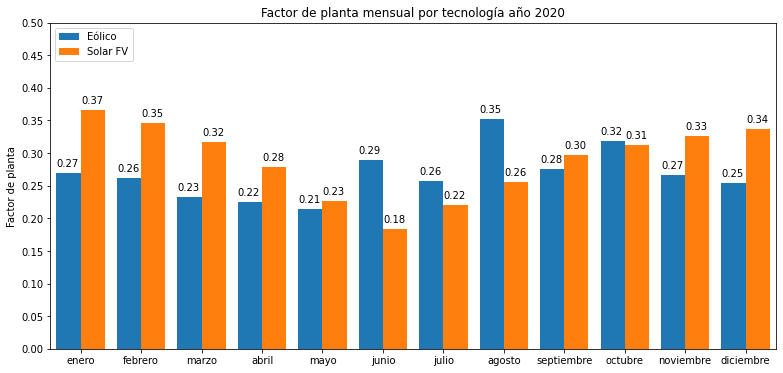

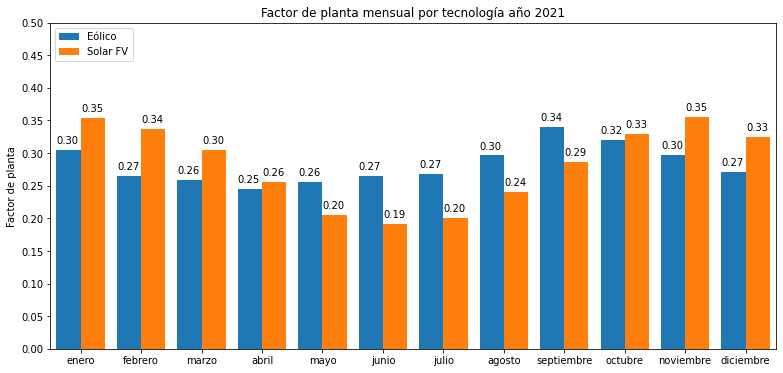

In [ ]:
fp_eolico_2020 = calcular_fp_2020(e, p_eol_2020)
fp_solar_2020 = calcular_fp_2020(s, p_sol_2020)

fp_eolico_2021 = calcular_fp_2021(e, p_eol_2021)
fp_solar_2021 = calcular_fp_2021(s, p_sol_2021)

print('Factor de planta eólica 2020', fp_eolico_2020)
print('Factor de planta solar 2020', fp_solar_2020)

print('Factor de planta eólica 2020', fp_eolico_2021)
print('Factor de planta solar 2020', fp_solar_2021)

meses = list(fp_eolico_2020.keys())
fp_eolico_2020 = np.array(list(fp_eolico_2020.values()))
fp_solar_2020 = np.array(list(fp_solar_2020.values()))
fp_eolico_2021 = np.array(list(fp_eolico_2021.values()))
fp_solar_2021 = np.array(list(fp_solar_2021.values()))
x_axis = np.arange(12)

# Se grafican los factores de planta mensuales calculados

plt.figure(figsize=(13,6))
plt.bar(x_axis-0.2, fp_eolico_2020, 0.4, label='Eólico')
plt.bar(x_axis+0.2, fp_solar_2020, 0.4, label='Solar FV')
for x,fp_e,fp_s in zip(x_axis,fp_eolico_2020,fp_solar_2020):
    plt.text(x=x-0.4,y=fp_e+0.01, s='%.2f'%(fp_e))
    plt.text(x=x+0.005,y=fp_s+0.01, s='%.2f'%(fp_s))
plt.xticks(x_axis, meses)
plt.ylabel('Factor de planta')
plt.yticks(np.arange(0,0.51,0.05))
plt.legend(loc='upper left')
plt.title('Factor de planta mensual por tecnología año 2020')
plt.xlim(-0.5,11.5)
plt.show()

plt.figure(figsize=(13,6))
plt.bar(x_axis-0.2, fp_eolico_2021, 0.4, label='Eólico')
plt.bar(x_axis+0.2, fp_solar_2021, 0.4, label='Solar FV')
for x,fp_e,fp_s in zip(x_axis,fp_eolico_2021,fp_solar_2021):
    plt.text(x=x-0.4,y=fp_e+0.01, s='%.2f'%(fp_e))
    plt.text(x=x+0.005,y=fp_s+0.01, s='%.2f'%(fp_s))
plt.xticks(x_axis, meses)
plt.ylabel('Factor de planta')
plt.yticks(np.arange(0,0.51,0.05))
plt.legend(loc='upper left')
plt.title('Factor de planta mensual por tecnología año 2021')
plt.xlim(-0.5,11.5)
plt.show()

In [ ]:
fp_sol_ano_2020 = dict()
fp_sol_ano_2021 = dict()
fp_eol_ano_2020 = dict()
fp_eol_ano_2021 = dict()

fp_sol_ano_2020['enero'] = fp_solar_2020[0]
fp_sol_ano_2020['febrero'] = fp_solar_2020[1]
fp_sol_ano_2020['marzo'] = fp_solar_2020[2]
fp_sol_ano_2020['abril'] = fp_solar_2020[3]
fp_sol_ano_2020['mayo'] =fp_solar_2020[4]
fp_sol_ano_2020['junio'] = fp_solar_2020[5]
fp_sol_ano_2020['julio'] = fp_solar_2020[6]
fp_sol_ano_2020['agosto'] = fp_solar_2020[7]
fp_sol_ano_2020['septiembre'] = fp_solar_2020[8]
fp_sol_ano_2020['octubre'] = fp_solar_2020[9]
fp_sol_ano_2020['noviembre'] = fp_solar_2020[10]
fp_sol_ano_2020['diciembre'] = fp_solar_2020[11]
 
fp_sol_ano_2021['enero'] = fp_solar_2021[0]
fp_sol_ano_2021['febrero'] = fp_solar_2021[1]
fp_sol_ano_2021['marzo'] =fp_solar_2021[2]
fp_sol_ano_2021['abril'] = fp_solar_2021[3]
fp_sol_ano_2021['mayo'] = fp_solar_2021[4]
fp_sol_ano_2021['junio'] = fp_solar_2021[5]
fp_sol_ano_2021['julio'] = fp_solar_2021[6]
fp_sol_ano_2021['agosto'] = fp_solar_2021[7]
fp_sol_ano_2021['septiembre'] = fp_solar_2021[8]
fp_sol_ano_2021['octubre'] = fp_solar_2021[9]
fp_sol_ano_2021['noviembre'] = fp_solar_2021[10]
fp_sol_ano_2021['diciembre'] = fp_solar_2021[11]

fp_eol_ano_2020['enero'] = fp_eolico_2020[0]
fp_eol_ano_2020['febrero'] = fp_eolico_2020[1]
fp_eol_ano_2020['marzo'] = fp_eolico_2020[2]
fp_eol_ano_2020['abril'] = fp_eolico_2020[3]
fp_eol_ano_2020['mayo'] = fp_eolico_2020[4]
fp_eol_ano_2020['junio'] = fp_eolico_2020[5]
fp_eol_ano_2020['julio'] = fp_eolico_2020[6]
fp_eol_ano_2020['agosto'] = fp_eolico_2020[7]
fp_eol_ano_2020['septiembre'] = fp_eolico_2020[8]
fp_eol_ano_2020['octubre'] = fp_eolico_2020[9]
fp_eol_ano_2020['noviembre'] = fp_eolico_2020[10]
fp_eol_ano_2020['diciembre'] = fp_eolico_2020[11]
 
fp_eol_ano_2021['enero'] = fp_eolico_2021[0]
fp_eol_ano_2021['febrero'] = fp_eolico_2021[1]
fp_eol_ano_2021['marzo'] = fp_eolico_2021[2]
fp_eol_ano_2021['abril'] = fp_eolico_2021[3]
fp_eol_ano_2021['mayo'] = fp_eolico_2021[4]
fp_eol_ano_2021['junio'] = fp_eolico_2021[5]
fp_eol_ano_2021['julio'] = fp_eolico_2021[6]
fp_eol_ano_2021['agosto'] = fp_eolico_2021[7]
fp_eol_ano_2021['septiembre'] = fp_eolico_2021[8]
fp_eol_ano_2021['octubre'] = fp_eolico_2021[9]
fp_eol_ano_2021['noviembre'] = fp_eolico_2021[10]
fp_eol_ano_2021['diciembre'] = fp_eolico_2021[11]

In [ ]:
#fp_eol_2020 = fp_anual_2020(e,p_eolica)
#fp_sol_2020 = fp_anual_2020(s,p_solar)

#fp_eol_2021 = fp_anual_2021(e,p_eolica)
#fp_sol_2021 = fp_anual_2021(s,p_solar)

#print('Factor de planta eólico 2020', fp_eol_2020)
#print('Factor de planta solar 2020', fp_sol_2020)

#print('Factor de planta eólico 2021', fp_eol_2021)
#print('Factor de planta solar 2021', fp_sol_2021)

fp_eol_2020 = calcular_fp_anual_2020(e,fp_eol_ano_2020)
fp_sol_2020 = calcular_fp_anual_2020(s,fp_sol_ano_2020)

print('Factor de planta eólico 2020', fp_eol_2020)
print('Factor de planta solar 2020', fp_sol_2020)

fp_eol_2021 = calcular_fp_anual_2021(e,fp_eol_ano_2021)
fp_sol_2021 = calcular_fp_anual_2021(s,fp_sol_ano_2021)

print('Factor de planta eólico 2021', fp_eol_2021)
print('Factor de planta solar 2021', fp_sol_2021)

Factor de planta eólico 2020 0.2745433488230249
Factor de planta solar 2020 0.29963021171362586
Factor de planta eólico 2021 0.2942813066736642
Factor de planta solar 2021 0.3197118759205621
